# Solving PDE with ModelingToolkit and NeuralPDE

Solving Poisson PDE Systems

$$
\partial^{2}_{x}u(x,y) + \partial^{2}_{y}u(x,y) = -\sin (\pi x) \sin (\pi y)
$$

with boundary conditions

$$
\begin{align}
u(0, y) &= 0 \\
u(1, y) &= 0 \\
u(x, 0) &= 0 \\
u(x, 1) &= 0 \\
\end{align}
$$

where

$x ∈ [0, 1], y ∈ [0, 1]$

In [1]:
using NeuralPDE
using Lux
using Plots
using Optimization
using OptimizationOptimJL
using ModelingToolkit
import ModelingToolkit: Interval
Plots.default(fmt=:png)

Precompiling OptimizationMTKExt


        Info Given OptimizationMTKExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


  ? OptimizationBase → OptimizationMTKExt


[ Info: Precompiling OptimizationMTKExt [ead85033-3460-5ce4-9d4b-429d76e53be9]


ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing OptimizationMTKExt [ead85033-3460-5ce4-9d4b-429d76e53be9].


[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [2]:
@variables x y u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

Differential(y) ∘ Differential(y)

2D PDE equations

In [3]:
eq  = Dxx(u(x, y)) + Dyy(u(x, y)) ~ -sinpi(x) * sinpi(y)

Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ -sinpi(x)*sinpi(y)

Boundary conditions

In [4]:
bcs = [
    u(0, y) ~ 0.0, u(1, y) ~ 0.0,
    u(x, 0) ~ 0.0, u(x, 1) ~ 0.0
]

4-element Vector{Equation}:
 u(0, y) ~ 0.0
 u(1, y) ~ 0.0
 u(x, 0) ~ 0.0
 u(x, 1) ~ 0.0

Space domains

In [5]:
domains = [
    x ∈ Interval(0.0, 1.0),
    y ∈ Interval(0.0, 1.0)
]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0 .. 1.0)
 Symbolics.VarDomainPairing(y, 0.0 .. 1.0)

Build a neural network for the PDE solver.

In [6]:
dim = 2
chain = Lux.Chain(Dense(dim, 16, Lux.σ), Dense(16, 16, Lux.σ), Dense(16, 1))

Chain(
    layer_1 = Dense(2 => 16, sigmoid_fast),  # 48 parameters
    layer_2 = Dense(16 => 16, sigmoid_fast),  # 272 parameters
    layer_3 = Dense(16 => 1),           # 17 parameters
)         # Total: 337 parameters,
          #        plus 0 states.

Discretization method: `PhysicsInformedNN()` (PINN).

In [7]:
dx = 0.05
discretization = PhysicsInformedNN(chain, GridTraining(dx))

PhysicsInformedNN{GridTraining{Float64}, Nothing, NeuralPDE.Phi{Chain{@NamedTuple{layer_1::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, typeof(NeuralPDE.numeric_derivative), Bool, Nothing, Nothing, Nothing, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(Chain(), GridTraining{Float64}(0.05), nothing, NeuralPDE.Phi{Chain{@NamedTuple{layer_1::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain(), (layer_1 = NamedTuple(), laye

Next we build our PDE system and discretize it.
Because this system is time-invariant, the corresponding problem is an `OptimizationProblem`.

In [8]:
@named pde_system = PDESystem(eq, bcs, domains, [x, y], [u(x, y)])
prob = discretize(pde_system, discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.3523319959640503 -0.26248645782470703; -0.541968047618866 -0.17249201238155365; … ; 0.27435970306396484 -0.031050905585289; -0.43380507826805115 0.023328958079218864], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.07882370799779892 -0.10076375305652618 … -0.12679961323738098 -0.2613614797592163; 0.16745401918888092 0.3212171196937561 … 0.05937356874346733 0.12254361808300018; … ; -0.2909601926803589 0.1045515164732933 … 0.0842587947845459 0.3912535309791565; -0.05128614231944084 -0.28735727071762085 … 0.3022613227367401 0.04392416775226593], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.006188894622027874 0.14982984960079193 … -0.16097421944141388 0.22301720082759857], bias = [0.0;;]))

The callback function records the loss value.

In [9]:
alg = OptimizationOptimJL.BFGS()

BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Flat}(LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, nothing, Flat())

Callback function

In [10]:
larr = Float64[]
callback = function (p, l)
    push!(larr, l)
    return false
end

#1 (generic function with 1 method)

Solve the problem.

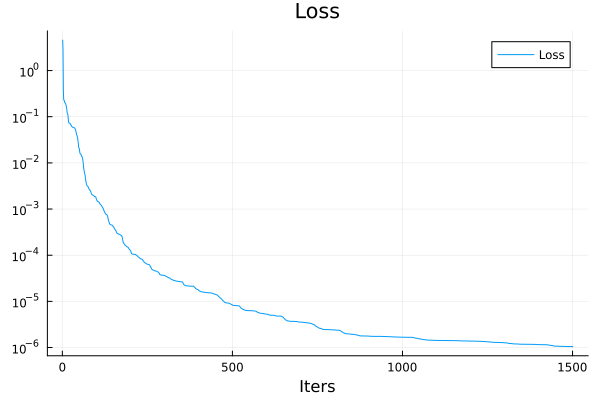

In [11]:
res = Optimization.solve(prob, alg, callback = callback, maxiters=1500)
plot(larr, xlabel="Iters", title="Loss", yscale=:log10, lab="Loss")

Plot the predicted solution of the PDE and compare it with the analytical solution to see the relative error.

In [12]:
xs, ys = [infimum(d.domain):dx/10:supremum(d.domain) for d in domains]
analytic_sol_func(x,y) = (sinpi(x)*sinpi(y))/(2pi^2)

phi = discretization.phi
u_predict = reshape([first(phi([x, y], res.u)) for x in xs for y in ys], (length(xs), length(ys)))
u_real = reshape([analytic_sol_func(x, y) for x in xs for y in ys], (length(xs), length(ys)))
diff_u = abs.(u_predict .- u_real)

201×201 Matrix{Float64}:
 3.27186e-5   3.35427e-5   3.42098e-5   …  5.64539e-6   6.83813e-6
 2.49165e-5   2.59467e-5   2.68212e-5      7.8841e-6    9.08917e-6
 1.72085e-5   1.84429e-5   1.95229e-5      1.01301e-5   1.13522e-5
 9.60486e-6   1.10415e-5   1.23248e-5      1.23786e-5   1.36221e-5
 2.1156e-6    3.75204e-6   5.23604e-6      1.46249e-5   1.58936e-5
 5.24991e-6   3.41639e-6   1.73446e-6   …  1.68643e-5   1.81621e-5
 1.24828e-5   1.04551e-5   8.57839e-6      1.90924e-5   2.04226e-5
 1.95745e-5   1.73561e-5   1.52879e-5      2.1305e-5    2.26706e-5
 2.65172e-5   2.41115e-5   2.18554e-5      2.34978e-5   2.49016e-5
 3.33033e-5   3.07141e-5   2.82741e-5      2.56669e-5   2.71113e-5
 3.99259e-5   3.71571e-5   3.45373e-5   …  2.78082e-5   2.92955e-5
 4.63782e-5   4.34342e-5   4.06389e-5      2.99182e-5   3.14501e-5
 5.26541e-5   4.95394e-5   4.65731e-5      3.1993e-5    3.35713e-5
 ⋮                                      ⋱               ⋮
 5.93776e-5   6.43781e-5   6.90536e-5      0.0

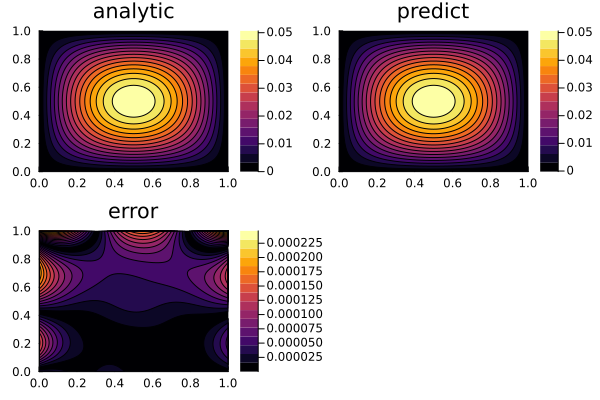

In [13]:
p1 = plot(xs, ys, u_real, linetype=:contourf, title = "analytic");
p2 = plot(xs, ys, u_predict, linetype=:contourf, title = "predict");
p3 = plot(xs, ys, diff_u, linetype=:contourf, title = "error");
plot(p1, p2, p3)